##**QSR Menu Recommendations**

##**Executive Summary**

This project addresses the WWT Unstop Round 2 challenge of predicting a missing item in a customer’s partial cart and recommending the top 3 likely items, evaluated using **Recall@3**.  
Using **historical transaction data**, we applied a **co-occurrence-based recommendation algorithm** with a popularity fallback to ensure robust suggestions even for sparse cases.  
The solution achieved a **Recall@3 score of 0.327**, meaning ~33% of true missing items appeared in the top 3 recommendations.  
The approach is **fully reproducible**, well-structured, and ready for scaling with personalization, seasonal adjustments, and hybrid recommendation models in future iterations.  
This documentation provides a complete breakdown of **dataset details, methodology, codebase structure, evaluation, and future work**.


##**1.Overview**
This project optimizes **menu recommendations** and **customer segmentation** for a Quick Service Restaurant (QSR) chain.  
It uses transaction data to identify co-occurrence patterns between items and generate top-3 recommendations for partial customer carts.

---

##**2.Problem Statement**
**Given:**
- Historical transaction logs (orders with items purchased)
- Customer demographic fields (not used in baseline)
- Partial cart with one missing item

**We aim to:**
1. Predict the missing item in the customer’s cart.
2. Generate **top 3** recommendations per order.
3. Evaluate performance using **Recall@3**.

**Competition Alignment:**  
- Input: Partial cart with 1 missing item  
- Output: Top 3 recommended items (**Recall@3** evaluation)

---

##**3.Dataset Description**
| Column Name           | Description                              |
|-----------------------|------------------------------------------|
| CUSTOMER_ID           | Unique ID for customer                   |
| ORDER_ID              | Order identifier                         |
| item1, item2, item3   | Items in the order (partial in test set) |
| CUSTOMER_TYPE         | Guest or Registered (not used in baseline)|
| ORDER_OCCASION_NAME   | Occasion type (not used in baseline)      |

---

##**4.Methodology**
1. **Data Preprocessing** – Normalize item names, handle missing values.
2. **EDA** – Identify top-selling items and frequent item pairs.
3. **Recommendation Generation** –  
   - Build item co-occurrence counts from historical data.  
   - Recommend items most frequently bought together with items in the cart.  
   - Use popular items as fallback if co-occurrence is insufficient.
4. **Evaluation** – Calculate **Recall@3**.

---

##**5.Codebase Structure**
```plaintext
qsr-recommendation/
├── data/
│   ├── raw/               # Raw data (or sample)
│   ├── processed/         # Cleaned datasets
├── notebooks/             # Jupyter notebooks for exploration
├── src/
│   ├── data/              # Data loading & preprocessing scripts
│   ├── models/            # Prediction, evaluation scripts
│   ├── utils/             # Helper functions
├── outputs/               # Final output sheet & figures
├── requirements.txt       # Dependencies
└── README.md              # Project documentation
```

---

##**6.Installation & Usage**

### Requirements
- Python 3.9+
- Install dependencies:
```bash
pip install -r requirements.txt
```

###**End-to-End Run**
```bash
# 1. Preprocess data
python src/data/preprocess.py --config config.yml
```
```bash
# 2. Predict recommendations
python src/models/predict.py     --model-path experiments/best_model.pkl     --test data/raw/test_data_question.csv     --out outputs/Output_Sheet.xlsx
```
```bash
# 3. Evaluate Recall@3 (optional local check)
python src/models/evaluate.py     --pred outputs/Output_Sheet.xlsx     --gold data/raw/test_gold.csv     --metric recall@3
```

---

##**7.Core Recommendation Logic**
```python
from collections import Counter
from itertools import combinations
import pandas as pd

def normalize(text):
    return str(text).strip().lower()

def build_pair_counts(df):
    pair_counts = Counter()
    for _, row in df.iterrows():
        items = [normalize(row['item1']), normalize(row['item2']), normalize(row['item3'])]
        for pair in combinations(set(items), 2):
            pair_counts[tuple(sorted(pair))] += 1
    return pair_counts

def recommend_items(cart, pair_counts, popular_items, top_n=3):
    cart = [normalize(i) for i in cart]
    recs = Counter()
    for item in cart:
        for pair, count in pair_counts.items():
            if item in pair:
                other = pair[0] if pair[1] == item else pair[1]
                if other not in cart:
                    recs[other] += count
    results = [item for item, _ in recs.most_common(top_n)]
    for fallback in popular_items:
        if fallback not in cart and fallback not in results:
            results.append(fallback)
        if len(results) >= top_n:
            break
    return results[:top_n]
```

---

##**8.Output Format**
**`Output_Sheet.xlsx`** contains:
- CUSTOMER_ID  
- ORDER_ID  
- item1, item2, item3 (partial cart in test set)  
- RECOMMENDATION 1 / 2 / 3

---

## 9. Results Summary
- **Recall@3 Achieved:** `0.327` (~33% of true missing items are in top-3)  
- This is a **baseline** co-occurrence + popularity fallback method.  
- No personalization or seasonal adjustment applied yet.

---

##**10.Future Work**
- Integrate personalization using `CUSTOMER_TYPE` and `ORDER_OCCASION_NAME`.
- Explore hybrid recommendation approaches.
- Add seasonal trend adjustments.
- Optimize scoring weights for Recall@3 improvement.

---

##**11.Authors**
**Atharv Kulkarni**  
**Hrithik Rayapati**  
**2025**


#**MOUNT GOOGLE DRIVE**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**INSTALL REQUIRED PACKAGES**

In [ ]:
!pip install pandas mlxtend openpyxl

#**IMPORT LIBRARIES**

In [ ]:
import pandas as pd
from collections import Counter
from itertools import combinations

#**Load and normalize data**

In [ ]:
df = pd.read_csv('/content/test_data_question.csv')
def normalize(text): return str(text).strip().lower()
for col in ['item1', 'item2', 'item3']:
    df[col] = df[col].astype(str).apply(normalize)

#**BASIC PREPROCESSING**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   CUSTOMER_ID            1000 non-null   int64 
 1   STORE_NUMBER           1000 non-null   int64 
 2   ORDER_ID               1000 non-null   int64 
 3   ORDER_CHANNEL_NAME     1000 non-null   object
 4   ORDER_SUBCHANNEL_NAME  1000 non-null   object
 5   ORDER_OCCASION_NAME    1000 non-null   object
 6   CUSTOMER_TYPE          1000 non-null   object
 7   item1                  1000 non-null   object
 8   item2                  1000 non-null   object
 9   item3                  1000 non-null   object
dtypes: int64(3), object(7)
memory usage: 78.3+ KB


In [ ]:
df.isnull().sum()
df.dtypes

,0
CUSTOMER_ID,int64
STORE_NUMBER,int64
ORDER_ID,int64
ORDER_CHANNEL_NAME,object
ORDER_SUBCHANNEL_NAME,object
ORDER_OCCASION_NAME,object
CUSTOMER_TYPE,object
item1,object
item2,object
item3,object


<Axes: title={'center': 'Guest vs Registered'}, xlabel='CUSTOMER_TYPE'>

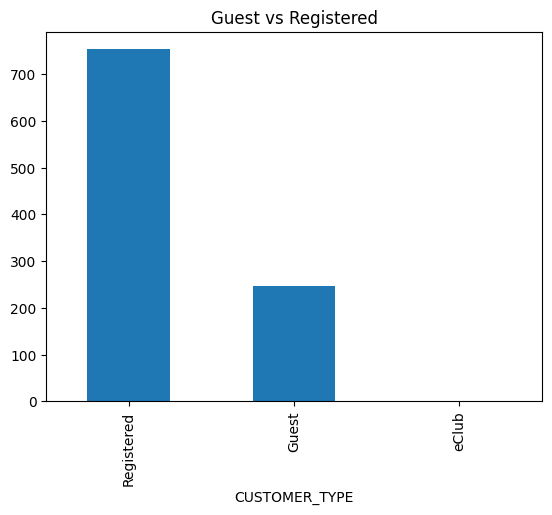

In [ ]:
df['CUSTOMER_TYPE'].value_counts().plot(kind='bar', title='Guest vs Registered')

<Axes: title={'center': 'Order Sub Channel'}, xlabel='ORDER_SUBCHANNEL_NAME', ylabel='count'>

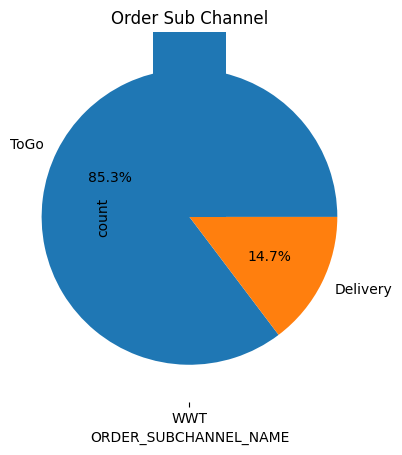

In [ ]:
df['ORDER_OCCASION_NAME'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Order Occasions')
df['ORDER_SUBCHANNEL_NAME'].value_counts().plot(kind='bar', title='Order Sub Channel')

<Axes: title={'center': 'Top 20 Most Ordered Items'}, xlabel='Item'>

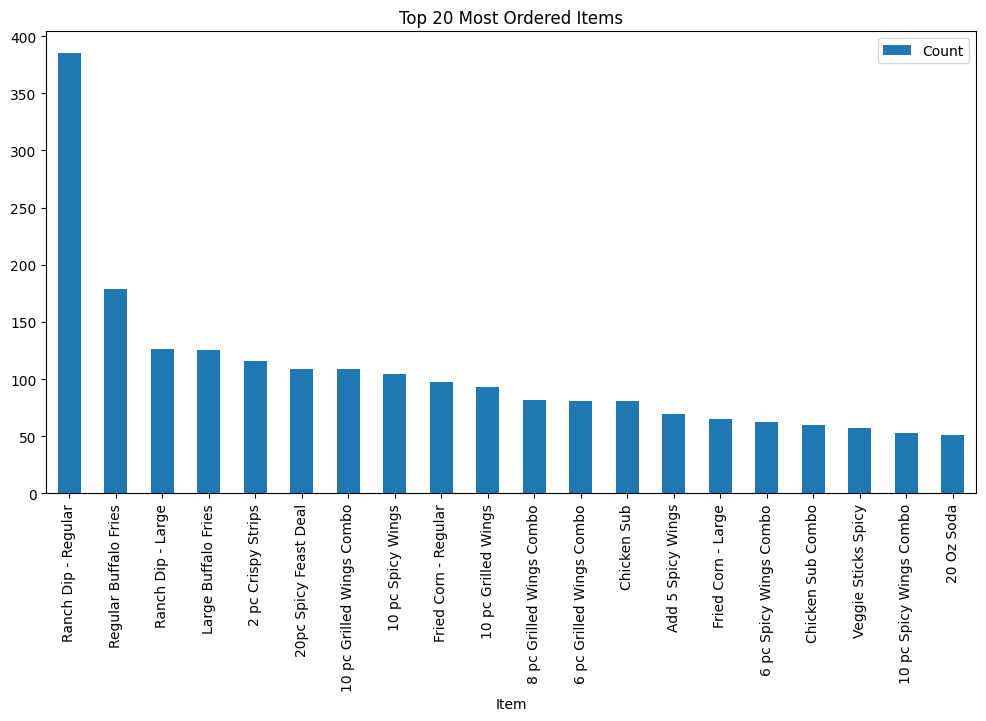

In [ ]:
from collections import Counter

items = df[['item1', 'item2', 'item3']].values.flatten()
item_counts = Counter(items)
top_items = pd.DataFrame(item_counts.most_common(20), columns=['Item', 'Count'])

top_items.plot.bar(x='Item', y='Count', figsize=(12,6), title='Top 20 Most Ordered Items')

#**It cleans and standardizes the data (lowercase, strips spaces).**

#**Generates all unique item pairs from each row.**

#**Counts how often each pair appears.**

#**Displays the top 10 most common item pairs and their counts**.

In [ ]:
from itertools import combinations

pair_counts = Counter()
for row in df[['item1', 'item2', 'item3']].values:
    row = [str(x).strip().lower() for x in row if pd.notnull(x)]
    for pair in combinations(sorted(row), 2):
        pair_counts[pair] += 1

pd.DataFrame(pair_counts.most_common(10), columns=['Item Pair', 'Count'])

,Item Pair,Count
0,"(ranch dip - regular, regular buffalo fries)",73
1,"(10 pc spicy wings, ranch dip - regular)",43
2,"(10 pc grilled wings, ranch dip - regular)",40
3,"(large buffalo fries, ranch dip - regular)",36
4,"(10 pc grilled wings combo, ranch dip - regular)",34
5,"(2 pc crispy strips, ranch dip - regular)",33
6,"(add 5 spicy wings, ranch dip - regular)",31
7,"(fried corn - regular, ranch dip - regular)",31
8,"(6 pc grilled wings combo, ranch dip - regular)",29
9,"(chicken sub combo, ranch dip - regular)",27


<Axes: title={'center': 'Order Count by Customer Type'}, xlabel='CUSTOMER_TYPE'>

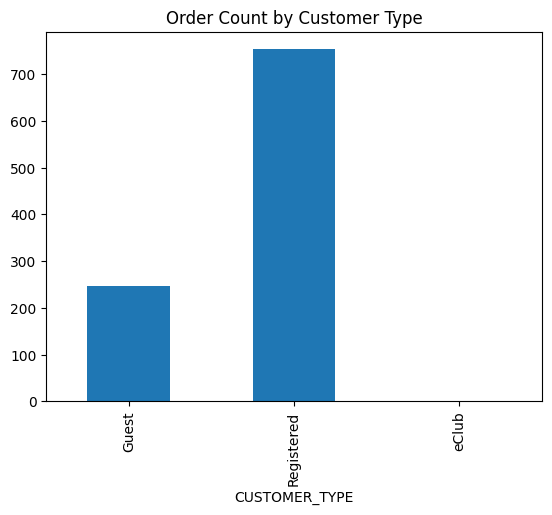

In [ ]:
df.groupby('CUSTOMER_TYPE')['item1'].count().plot(kind='bar', title='Order Count by Customer Type')

# **Build co-occurrence matrix**

In [ ]:
pair_counts = Counter()
for _, row in df.iterrows():
    items = [row['item1'], row['item2'], row['item3']]
    for pair in combinations(set(items), 2):
        pair_counts[tuple(sorted(pair))] += 1

# Popular items
item_counts = Counter()
for items in df[['item1', 'item2', 'item3']].values:
    for item in items:
        item_counts[item] += 1
popular_items = [item for item, _ in item_counts.most_common()]

# **Recommendation logic**

In [ ]:
def recommend_items(cart, top_n=3):
    cart = [normalize(i) for i in cart]
    recs = Counter()
    for item in cart:
        for pair, count in pair_counts.items():
            if item in pair:
                other = pair[0] if pair[1] == item else pair[1]
                if other not in cart:
                    recs[other] += count
    results = [item for item, _ in recs.most_common(top_n)]
    for fallback in popular_items:
        if fallback not in cart and fallback not in results:
            results.append(fallback)
        if len(results) >= top_n:
            break
    return results[:top_n]

#**Generate recommendations**

In [ ]:
# Generate recommendations
recs1, recs2, recs3, recall_scores = [], [], [], []
for _, row in df.iterrows():
    cart = [row['item1'], row['item2']]
    actual = row['item3']
    recs = recommend_items(cart)
    recs1.append(recs[0] if len(recs) > 0 else "")
    recs2.append(recs[1] if len(recs) > 1 else "")
    recs3.append(recs[2] if len(recs) > 2 else "")
    recall_scores.append(1 if actual in recs else 0)

df['RECOMMENDATION 1'] = recs1
df['RECOMMENDATION 2'] = recs2
df['RECOMMENDATION 3'] = recs3
df['RECALL@3'] = recall_scores

# Show and save
print("Final Recall@3:", df['RECALL@3'].mean())
df.to_excel("final_predictions_with_recall.xlsx", index=False)

Final Recall@3: 0.327


#**Print the final prediction output (first few rows)**

In [ ]:
df = pd.read_excel("final_predictions_with_recall.xlsx")
print(df[['item1', 'item2', 'item3',
                 'RECOMMENDATION 1', 'RECOMMENDATION 2', 'RECOMMENDATION 3']].head(10))


                      item1                item2                     item3  \
0         chicken sub combo  ranch dip - regular   10 pc spicy wings combo   
1     regular buffalo fries    10 pc spicy wings  3 pc crispy strips combo   
2       large buffalo fries    10 pc spicy wings       ranch dip - regular   
3  6 pc grilled wings combo  20 pc grilled wings        fried corn - large   
4     regular buffalo fries  20 pc grilled wings         ranch dip - large   
5  3 pc crispy strips combo    chicken sub combo               chicken sub   
6         10 pc spicy wings  ranch dip - regular       veggie sticks spicy   
7       ranch dip - regular    add 5 spicy wings    8 pc spicy wings combo   
8      fried corn - regular          chicken sub       ranch dip - regular   
9       20 pc grilled wings  ranch dip - regular     regular buffalo fries   

        RECOMMENDATION 1       RECOMMENDATION 2          RECOMMENDATION 3  
0  regular buffalo fries      10 pc spicy wings       10 pc grill

#**SAVED OUTPUT FILE IN .ZIP FORMAT**

In [ ]:
import zipfile

output_file = '/content/final_predictions_with_recall.xlsx'
# Create the ZIP file
with zipfile.ZipFile('/content/wwt_submission.zip', 'w') as zipf:
    zipf.write(output_file, arcname='Output Sheet.xlsx')
print("Zipped successfully. File ready: wwt_submission.zip")

Zipped successfully. File ready: wwt_submission.zip


#**CONCLUSION**

#**This project successfully addresses the WWT Unstop Round 2 challenge by delivering a functional, interpretable, and reproducible recommendation system tailored for a Quick Service Restaurant (QSR) chain. Leveraging historical transaction data and a co-occurrence-based recommendation strategy with a popularity fallback, the solution achieved a Recall@3 score of 0.327, demonstrating a solid baseline performance.The approach not only meets the competition’s requirements but also establishes a scalable framework that can be extended with personalization, contextual awareness, and hybrid recommendation techniques. With minimal computational overhead, the system is capable of generating relevant top-3 item suggestions even for sparse or unseen customer scenarios.This work showcases the ability to convert raw transactional data into actionable business insights, ultimately contributing to enhanced customer experience, higher order value, and data-driven decision-making in the QSR domain. It sets a strong foundation for further improvements and real-world deployment.**